# Text Analysis

This notebook finds the correlation between numerical and text self reports.
(make sure to have Command Line Tools for Xcode installed on your MAC to be able to install emnetter[text])

In [46]:
%reload_ext autoreload
%autoreload 3

# imports
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, GroupShuffleSplit, permutation_test_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# from bertopic import BERTopic
from embetter.text import SentenceEncoder

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# 1. DATA
DATA = pd.read_csv('data/behavioral_data/PyEEGW_behavioral_data.csv')
X = DATA['eng_text'].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x<=5 else 1).values

In [53]:
# 2. Pipeline
from sklearn.pipeline import Pipeline
CV = GroupShuffleSplit(n_splits=200, test_size=0.2)

X_t = SentenceEncoder('all-MiniLM-L6-v2').fit_transform(X)

# Convert texts to vectors (embeddings) and predict hypnosis_depth
pipe = make_pipeline(
    VarianceThreshold(threshold=0.0),
    StandardScaler(),
    SVC(kernel='linear')
)

scores = cross_val_score(pipe, X_t, y, cv=CV, groups=DATA['id'], n_jobs=-1)
scores.mean()

0.6493181818181819

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.0s finished
/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


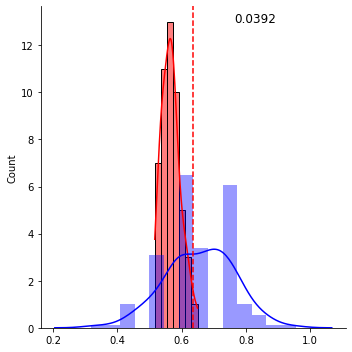

In [44]:
# permutation test
from sklearn.model_selection import permutation_test_score
import seaborn as sns
import matplotlib.pyplot as plt

obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X_t, y, cv=CV, scoring='accuracy', n_permutations=50, groups=DATA['id'], n_jobs=-1, verbose=1)

sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores, kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [15]:
from sklearn.dummy import DummyClassifier
CHANCE_CV = GroupShuffleSplit(n_splits=50, test_size=0.2)
chance_model = DummyClassifier(strategy='most_frequent')
chance_scores = cross_val_score(chance_model, X, y, groups=DATA['id'], cv=CHANCE_CV, scoring='accuracy', n_jobs=-1)

## GPT2
### huggingface

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = DATA.loc[0, 'eng_text']
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

### github

In [ ]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('gpt2')  # or any other checkpoint
word_embeddings = model.transformer.wte.weight  # Word Token Embeddings 
position_embeddings = model.transformer.wpe.weight  # Word Position Embeddings 

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text_index = tokenizer.encode('man',add_prefix_space=True)
vector = model.transformer.wte.weight[text_index,:]